<a href="https://colab.research.google.com/github/bharatgirdhar/SpatialTransformers/blob/main/Spatial_Transformer_Session12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline


Spatial Transformer Networks Tutorial
=====================================
**Author**: `Ghassen HAMROUNI <https://github.com/GHamrouni>`_

.. figure:: /_static/img/stn/FSeq.png

In this tutorial, you will learn how to augment your network using
a visual attention mechanism called spatial transformer
networks. You can read more about the spatial transformer
networks in the `DeepMind paper <https://arxiv.org/abs/1506.02025>`__

Spatial transformer networks are a generalization of differentiable
attention to any spatial transformation. Spatial transformer networks
(STN for short) allow a neural network to learn how to perform spatial
transformations on the input image in order to enhance the geometric
invariance of the model.
For example, it can crop a region of interest, scale and correct
the orientation of an image. It can be a useful mechanism because CNNs
are not invariant to rotation and scale and more general affine
transformations.

One of the best things about STN is the ability to simply plug it into
any existing CNN with very little modification.



In [ ]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

Loading the data
----------------

In this post we experiment with the classic MNIST dataset. Using a
standard convolutional network augmented with a spatial transformer
network.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    ])), batch_size=64, shuffle=True, num_workers=4)

Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

.. figure:: /_static/img/stn/stn-arch.png

.. Note::
   We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.




In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 4 * 4, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 4* 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
       # print(x.size())
        x = self.stn(x)
       # print(x.size())
        # Perform the usual forward pass
        x = self.conv1(x)
        #print(len(x))
        x=F.relu(F.max_pool2d(x,2))
        #print(len(x))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(len(x))
        #print(x.size())
        x = x.view(-1, 500)
        #print(x.size())
        #print(len(x))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        #print(len(x))
        return F.log_softmax(x, dim=1)




In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10           [-1, 10, 28, 28]             760
           Conv2d-11           [-1, 20, 10, 10]           5,020
        Dropout2d-12           [-1, 20, 10, 10]               0
           Linear-13                   [-1, 50]          25,050
           Linear-14                   

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See 

Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #print(len(output),len(target))
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify ali

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.342059
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.167587


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 1.9807, Accuracy: 3139/10000 (31%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.087098
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.839127

Test set: Average loss: 1.7891, Accuracy: 3725/10000 (37%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.099454
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.990393

Test set: Average loss: 1.6884, Accuracy: 4104/10000 (41%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.877592
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.672381

Test set: Average loss: 1.6212, Accuracy: 4188/10000 (42%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.800085
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.688316

Test set: Average loss: 1.5879, Accuracy: 4318/10000 (43%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.800865
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.735284

Test set: Average loss: 1.5426, Accuracy: 4527/10000 (45%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.809286
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.655217

Test set: Average loss: 1.5263, Accuracy: 4587/10000 (46%)

Tra

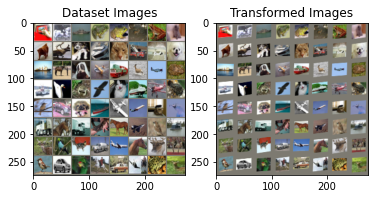

In [ ]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 50 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()